## Next frame prediction based on CNN-LSTM



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%pip install cartopy
%pip install tensorflow
%pip install keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 105.5 MB/s eta 0:00:00


In [3]:
import os
import numpy as np
import xarray as xr
from datetime import datetime, timedelta
import pickle
import time
import random
from tqdm import tqdm
import numpy as np
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Reshape, Input
from datetime import datetime, timedelta
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, TimeDistributed, Conv2D, ConvLSTM2D
import cartopy as crs
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cv2
from matplotlib.patches import Polygon

### Globals

In [4]:
# Caution: Not a good idea to use globals in programming. But ....

# Contains listing of all wavelength in nm
G_Wavelengths = [0] * 11

# Max reflectance of each wavelength
GRmax = [0] * 11

## Utility Functions

Files downloaded from earthaccess as granules. These are post-processed to aggregate 7 day moving average into a numpy file marked by a single date. It contains reading for all 22 channels for all lat, lon in one numpy array. The lat, lon information is in a separate metadate file.
Note that though there are 22 channels, only 11 of them carry valid values. The rest of the channels are NaNs, except the last one channel-id 21 which carries the chla readings

In [5]:
def get_numpy_data_from_file(data_path=None, metadata_path=None):
    data = np.load(data_path)
    with open(metadata_path, "rb") as f:
        metadata = pickle.load(f)

    # Bad coding habit, but using this for now
    global G_Wavelengths
    G_Wavelengths = metadata["wavelengths"][0:11]
    lat = metadata['lat']
    lon = metadata['lon']

    from datetime import datetime
    datestr = data_path.split('_')[-1]
    datestr = datestr.split('.')[0]
    start_date = datetime.strptime(datestr, "%Y-%m-%d")
    return (lat, lon, start_date, data)


### Plotting all wavelengths for a given day

This is meant to read the raw npy file and metadata and plot. The last channel (id: 21) is the 'chla' wavelength. It is not in the same scale as the other wavelengths. So, we'll exclude chla channel in this plot

In [6]:
def plot_day_spectrum_by_file(day_index, data_path="../Images/composite_data_S3_2019-01-07.npy", \
                      metadata_path="../Images/composite_metadata_S3_2019-01-07.pkl"):
    """
    Plots the mean spectrum for a given day index.

    Parameters:
        day_index (int): The index of the day (0 = first day in composite array).
        data_path (str): Path to the saved numpy array.
        metadata_path (str): Path to the saved metadata (pickle file).
    """
    # Load data and metadata
    data = np.load(data_path)
    print("data.shape:", data.shape)
    with open(metadata_path, "rb") as f:
        metadata = pickle.load(f)

    #CHLA
    global G_Wavelengths
    G_Wavelengths = metadata["wavelengths"][0:11]
    print("G_Wavelengths:", G_Wavelengths)
    wavelengths = G_Wavelengths

    # Sanity check for day index
    if day_index < 0 or day_index >= data.shape[0]:
        print(f"Day index {day_index} is out of range. Data has {data.shape[0]} days.")
        return

    # Get the day's data
    day_data = data[day_index]  # shape (h, w, c)

    #CHLA
    day_data = day_data[:,:,0:11]

    # Average over h, w (ignoring NaNs)
    mean_spectrum = np.nanmean(day_data, axis=(0, 1))  # shape (c,)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(wavelengths, mean_spectrum, marker='o', linestyle='-')
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Mean Intensity (sr$^{-1}$ m$^{-2}$ nm$^{-1}$)")
    plt.title(f"Mean Spectrum for Day Index {day_index}")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

### Plotting all wavelengths for an image

The input is an image in the shape (93, 164, X). However, this function will just pick the first 11 channels. Plot the mean avergaes of the 11 different wavelengths for the entire lake image.

In [7]:
def plot_image_spectrum(image1, image2=None):

    """
    Plots the mean spectrum of image (93, 163, 14)

    Parameters:
        image (numpy array): The image (93, 163, 14)
    """

    global G_Wavelengths
    wavelengths = G_Wavelengths

    # Average over h, w (ignoring NaNs)
    mean_spectrum1 = np.nanmean(image1[:, :, :11], axis=(0, 1))  # shape (11,)
    if image2 is not None:
      mean_spectrum2 = np.nanmean(image2[:, :, :11], axis=(0, 1))  # shape (11,)

    print(mean_spectrum1.shape, wavelengths.shape)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(wavelengths, mean_spectrum1, marker='o', linestyle='-')
    if image2 is not None:
      plt.plot(wavelengths, mean_spectrum2, marker='o', linestyle='-.')
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Mean Intensity (sr$^{-1}$ m$^{-2}$ nm$^{-1}$)")
    plt.title(f"Mean Spectrum Image")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(['True', 'Pred'])
    plt.tight_layout()
    plt.show()

### Chlrophyll-a segmentation plot
Since this reading has a large range from 0.1 to 1000, we we'll have to plot using log of the values. Chla readings are in band 21.


In [8]:
def plot_chla_image(data_path="../Images/composite_data_S3_2019-01-07.npy",
                    metadata_path="../Images/composite_metadata_S3_2019-01-07.pkl",
                    band_index=21, min_thresh=2.5, max_thresh=7.0):

    lat, lon, start_date, data = get_numpy_data_from_file(data_path, metadata_path)

    min_thresh = 2.5
    max_thresh = 7.0

    # Plot band 10 (zero-based indexing)
    band_index = 21

    # need to use log because of the spread of data
    normd = np.log(data[0][:,:,band_index])

    # Filter the higher value of chla
    mask = (normd > min_thresh) & (normd < max_thresh) & np.isfinite(normd)  # True between thresholds

    # Set elements where mask is False to NaN
    selected = np.where(mask, normd, np.nan)

    selected_after = selected.astype(np.uint8)

    # 4. Use OpenCV to find contours
    contours, _ = cv2.findContours(selected_after, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # --- Plot on Cartopy ---
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

    # Set map extent to Lake Erie region
    ax.set_extent([-83.62, -82.0, 41.34, 42.27], crs=ccrs.PlateCarree())
    #ax.set_extent([-83.25, -82.5, 41.4, 41.6], crs=ccrs.PlateCarree())

    # Add map features
    ax.coastlines(resolution='10m')
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none')
    ax.gridlines(draw_labels=True)

    # Plot reflectance
    im = ax.pcolormesh(lon, lat, normd, cmap='jet', shading='auto', vmin=0, vmax=7, transform=ccrs.PlateCarree())

    # Add colorbar and labels
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', label='log(chloro_a)')


    # 5. Overlay contours back on map
    for cnt in contours:
        # cnt is an array of shape (N, 1, 2) with (row, col) indices
        cnt = cnt.squeeze()  # shape (N, 2)
        if cnt.ndim != 2:
            continue  # skip if contour is malformed

        # Convert from array indices to lat/lon
        y_idx, x_idx = cnt[:, 1], cnt[:, 0]
        contour_lons = lon[x_idx]
        contour_lats = lat[y_idx]

        #ax.plot(contour_lons, contour_lats, color='red', linewidth=1.2, transform=ccrs.PlateCarree())
        poly = Polygon(
            np.column_stack((contour_lons, contour_lats)),
            closed=True,
            facecolor='none',
            edgecolor='red',
            linewidth=0.8,
            alpha=1.0,
            transform=ccrs.PlateCarree()
        )
        ax.add_patch(poly)

    plt.title(f"Chlorophyll-a in range [{min_thresh}, {max_thresh}] around {start_date.date()}")
    plt.show()


### NDCI plot
NDCI stands for Normalized Difference Chlorophyll Index. It is a remote sensing index derived from satellite data to estimate chlorophyll-a concentration, particularly in inland and coastal waters, where traditional ocean color algorithms struggle due to high turbidity and colored dissolved organic matter (CDOM).

Pass the wavelength index for wavelength 665 and 709

In [9]:
def plot_ndci(data_path="../Images/composite_data_S3_2019-01-07.npy",
              metadata_path="../Images/composite_metadata_S3_2019-01-07.pkl",
              band_665_index=7, band_708_index=10):
    import cartopy as crs
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    import cv2
    from matplotlib.patches import Polygon

    lat, lon, start_date, data = get_numpy_data_from_file(data_path, metadata_path)

    # Suppose you know the band indices:
    band_665_index = 7   # replace with actual index for 665 nm
    band_708_index = 10  # replace with actual index for 708 nm

    # Extract the two bands
    rrs_665 = data[0][:, :, band_665_index]
    rrs_708 = data[0][:, :, band_708_index]

    # Compute NDCI safely (avoid division by zero)
    numerator = rrs_708 - rrs_665
    denominator = rrs_708 + rrs_665
    ndci = np.where(denominator != 0, numerator / denominator, np.nan)

    ndci = np.where(np.isfinite(denominator) & (denominator != 0), numerator / denominator, np.nan)

    # Filter the higher value of chla
    #mask = (ndci > min_thresh) & (ndci < max_thresh) & np.isfinite(ndci)  # True between thresholds

    # Set elements where mask is False to NaN
    #selected = np.where(mask, ndci, np.nan)

    # 4. Use OpenCV to find contours
    # contours, _ = cv2.findContours(selected_after, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # --- Plot on Cartopy ---
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

    # Set map extent to Lake Erie region
    ax.set_extent([-83.62, -82.0, 41.34, 42.27], crs=ccrs.PlateCarree())
    #ax.set_extent([-83.25, -82.5, 41.4, 41.6], crs=ccrs.PlateCarree())

    # Add map features
    ax.coastlines(resolution='10m')
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none')
    ax.gridlines(draw_labels=True)

    # Plot reflectance
    im = ax.pcolormesh(lon, lat, ndci, cmap='jet', shading='auto', vmin=-1, vmax=1, transform=ccrs.PlateCarree())

    # Add colorbar and labels
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', label='log(chloro_a)')

    plt.title(f"NDCI [range: -1 to +1] around {start_date.date()}")
    plt.show()


### Plot single channel

Plot reflectance of a single channel (waveindex) for a given date (start_date). lat, lon is provided to help the geo-plot. 'data' contains npy data for all channels.


In [10]:
def plot_single_channel(lat, lon, start_date, data, waveindex):
    # Filter out specific wavelength
    rrs = data[0][:, :, waveindex]

    vmin = np.nanmin(rrs)-0.01
    vmax = np.nanmax(rrs)+0.01

    print(f'Min: {np.nanmin(data)}, Max: {np.nanmax(data)}')

    # --- Plot on Cartopy ---
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

    # Set map extent to Lake Erie region
    ax.set_extent([-83.62, -82.0, 41.34, 42.27], crs=ccrs.PlateCarree())
    #ax.set_extent([-83.25, -82.5, 41.4, 41.6], crs=ccrs.PlateCarree())

    # Add map features
    ax.coastlines(resolution='10m')
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none')
    ax.gridlines(draw_labels=True)

    # Plot reflectance
    im = ax.pcolormesh(lon, lat, rrs, cmap='jet', shading='auto', vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())

    # Add colorbar and labels
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', label=f'Wavelength index {waveindex}')

    plt.title(f"RRS [range: {vmin:.2f} to {vmax:.2f}] around {start_date.date()}")
    plt.show()


### Single channel EDA plot

Min: -0.015531998127698898, Max: 0.03638800233602524


/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


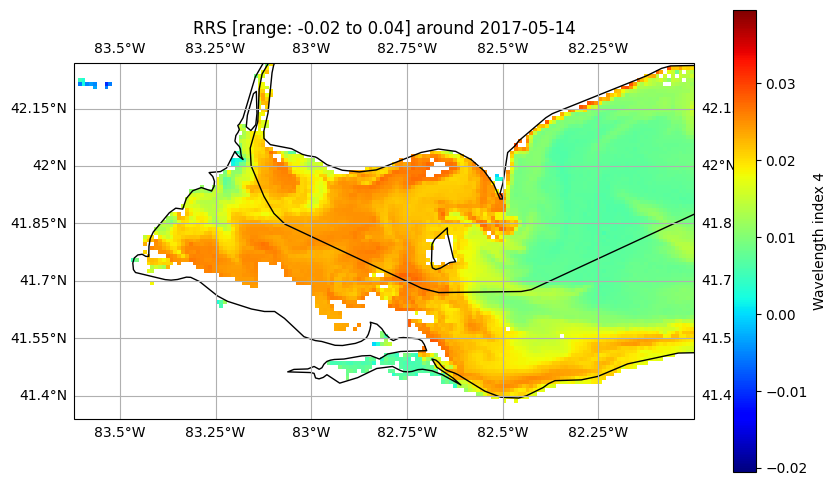

In [11]:
data_path="/content/drive/MyDrive/MIDS-210/CNN-LSTM/images/composite_data_S3_2017-05-14.npy"
metadata_path="/content/drive/MyDrive/MIDS-210/CNN-LSTM/images/composite_metadata_S3_2017-05-14.pkl"


lat, lon, start_date, data = get_numpy_data_from_file(data_path, metadata_path)
waveindex=4
plot_single_channel(lat, lon, start_date, data[:,:,:,0:11], waveindex)

### Plot of mean values across spectrum EDA for one day

data.shape: (1, 93, 163, 22)
G_Wavelengths: [400. 412. 443. 490. 510. 560. 620. 665. 674. 681. 709.]


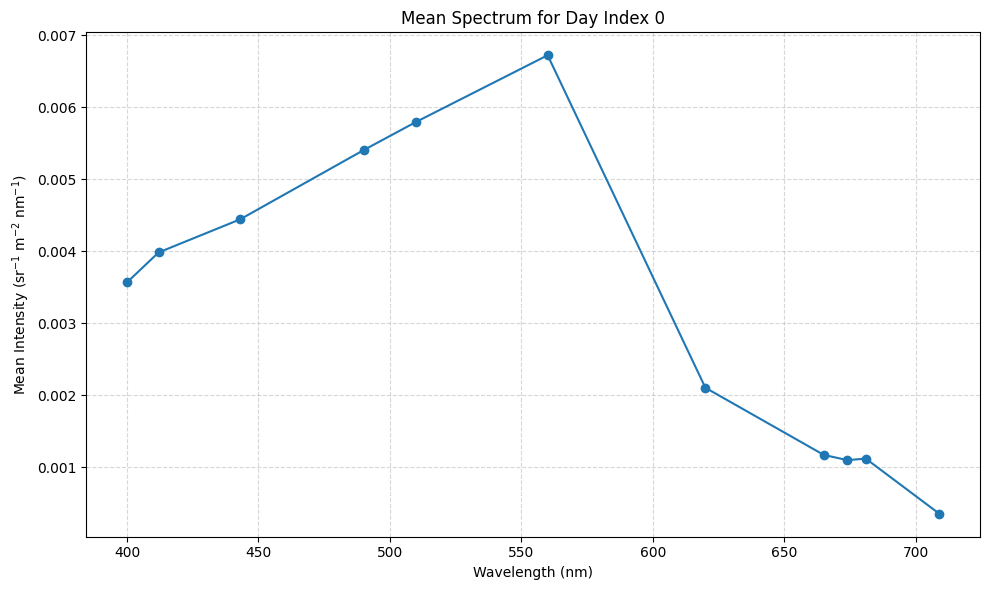

In [12]:
plot_day_spectrum_by_file(0, data_path="/content/drive/MyDrive/MIDS-210/CNN-LSTM/images/composite_data_S3_2017-07-30.npy",
                      metadata_path="/content/drive/MyDrive/MIDS-210/CNN-LSTM/images/composite_metadata_S3_2017-07-30.pkl")

### Chlorophyll-a reading EDA

/tmp/ipython-input-8-1666601476.py:22: RuntimeWarning: invalid value encountered in cast
  selected_after = selected.astype(np.uint8)


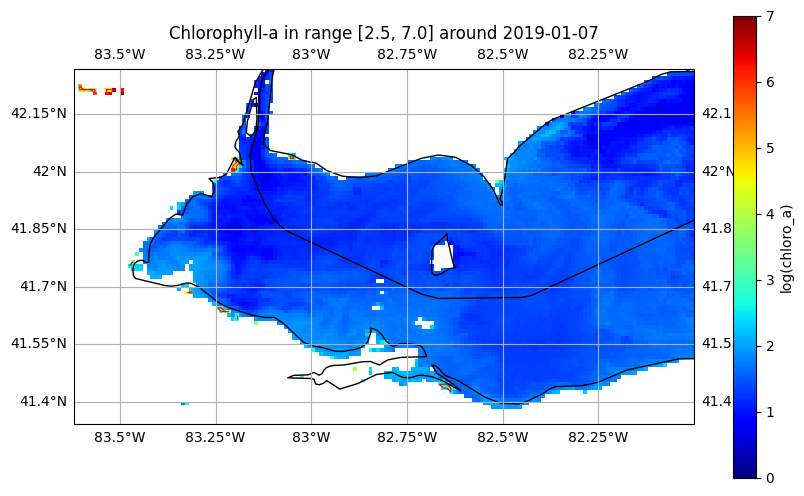

In [13]:
plot_chla_image(data_path="/content/drive/MyDrive/MIDS-210/CNN-LSTM/images/composite_data_S3_2019-01-07.npy",
                metadata_path="/content/drive/MyDrive/MIDS-210/CNN-LSTM/images/composite_metadata_S3_2019-01-07.pkl",
                band_index=21, min_thresh=2.5, max_thresh=7.0)

### Plot NDCI EDA

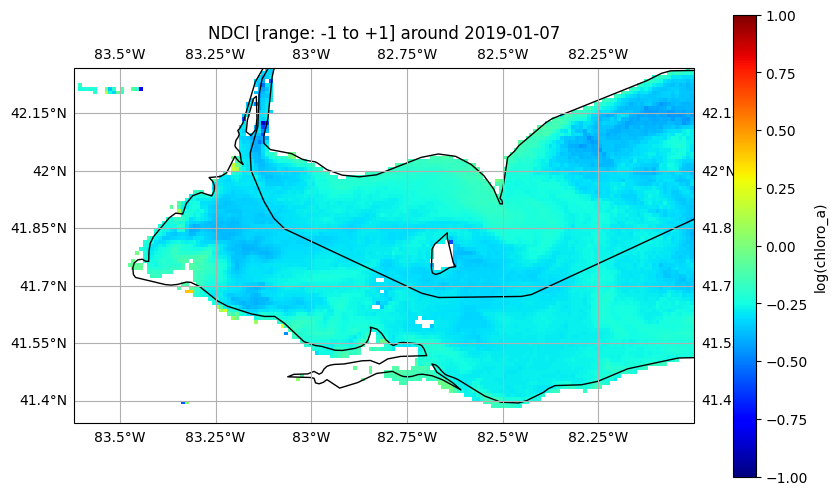

In [14]:
plot_ndci(data_path="/content/drive/MyDrive/MIDS-210/CNN-LSTM/images/composite_data_S3_2019-01-07.npy",
          metadata_path="/content/drive/MyDrive/MIDS-210/CNN-LSTM/images/composite_metadata_S3_2019-01-07.pkl",
          band_665_index=7, band_708_index=10)

## Aggregate all the data into a huge numpy array

In [15]:
def nanratio(arr):
  # Count total values
  total = arr.size

  # Count NaNs
  nan_count = np.isnan(arr).sum()

  # Count non-NaNs
  non_nan_count = total - nan_count

  # Ratio of NaNs to non-NaNs
  ratio = nan_count * 100 / total if non_nan_count != 0 else np.inf

  return ratio

In [16]:
# Directory containing the files
directory = "/content/drive/MyDrive/MIDS-210/CNN-LSTM/images"
datafiles = []
metadatafiles = []

# Example: rename all .txt files by adding a prefix
for filename in os.listdir(directory):
    if filename.startswith("composite_data_S3_"):
        datafiles.append(filename)
    if filename.startswith("composite_metadata_S3_"):
        metadatafiles.append(filename)

datafiles.sort()
metadatafiles.sort()
allfiles = zip(datafiles, metadatafiles)

In [17]:
# Initialize list to collect arrays
array_list = []
dates_list = []

for npy,metanpy in list(allfiles):
    #print(npy, metanpy)
    datapath = f'{directory}/{npy}'
    metadatapath = f'{directory}/{metanpy}'
    lat, lon, start_date, dailydata = get_numpy_data_from_file(datapath, metadatapath)
    #print(lat.shape, lon.shape, dailydata.shape)

    if np.isnan(dailydata).all() == True:
      print(f'Skipping file {datapath} as all data is NaN')
      continue

    if nanratio(dailydata[:,:,:,0:11]) > 65:
      print(f'Skipping file {datapath} as more than 65% of data is NaN')
      continue

    array_list.append(dailydata)
    dates_list.append(start_date)

# Stack them into shape (N, H, W, C)
stacked_array = np.concatenate(array_list, axis=0)

#cols = np.r_[0:11, 21]  # combines slice 0:11 wavelength with 21 (chla)
#stacked_array = stacked_array[:,:,:,cols] #ignore all other channels since they are NaNs
stacked_array = stacked_array[:,:,:,0:11] #ignore all other channels since they are NaNs
stacked_array.shape

Skipping file /content/drive/MyDrive/MIDS-210/CNN-LSTM/images/composite_data_S3_2017-01-01.npy as more than 65% of data is NaN
Skipping file /content/drive/MyDrive/MIDS-210/CNN-LSTM/images/composite_data_S3_2017-01-08.npy as more than 65% of data is NaN
Skipping file /content/drive/MyDrive/MIDS-210/CNN-LSTM/images/composite_data_S3_2017-01-15.npy as more than 65% of data is NaN
Skipping file /content/drive/MyDrive/MIDS-210/CNN-LSTM/images/composite_data_S3_2017-01-22.npy as more than 65% of data is NaN
Skipping file /content/drive/MyDrive/MIDS-210/CNN-LSTM/images/composite_data_S3_2017-01-29.npy as more than 65% of data is NaN
Skipping file /content/drive/MyDrive/MIDS-210/CNN-LSTM/images/composite_data_S3_2017-02-12.npy as more than 65% of data is NaN
Skipping file /content/drive/MyDrive/MIDS-210/CNN-LSTM/images/composite_data_S3_2017-03-19.npy as more than 65% of data is NaN
Skipping file /content/drive/MyDrive/MIDS-210/CNN-LSTM/images/composite_data_S3_2017-03-26.npy as more than 65%

(168, 93, 163, 11)

In [18]:
ratios = []
for i in range(len(stacked_array)):
  ratios.append(nanratio(stacked_array[i]))

In [19]:
np.nanmin(ratios), np.nanmax(ratios), len(ratios)

(np.float64(45.35259581766607), np.float64(64.88554654000923), 168)

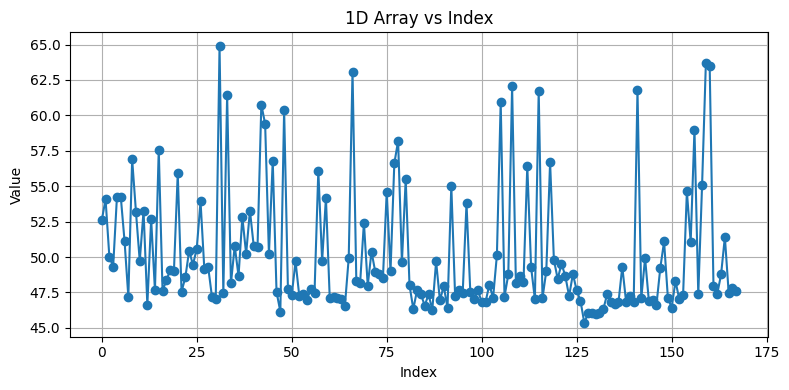

In [20]:
# Plot
plt.figure(figsize=(8, 4))
plt.plot(ratios, marker='o', linestyle='-')
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("1D Array vs Index")
plt.grid(True)
plt.tight_layout()
plt.show()

### Look for Outliers

In [21]:
positives = np.sum(stacked_array > 0)
negatives = np.sum(stacked_array < 0)
total = positives + negatives

# Count of all values greater than 0
print(f'Count all elements greater than 0: {positives} [{(positives*100)/total}]%')

# Count of all values less than 0
print(f'Count all elements less than 0: {negatives} [{(negatives*100)/total}]%')

# Count of all values less than -0.00016
print(f'Count all elements less than -0.00016: {np.sum(stacked_array < -0.00016)}')

Count all elements greater than 0: 13587021 [97.4023010621831]%
Count all elements less than 0: 362363 [2.5976989378168955]%
Count all elements less than -0.00016: 302639


In [22]:
# print min and max for the entire stacked_array (across 225 weeks)
print(np.nanmin(stacked_array), np.nanmax(stacked_array))

# print min and max for week 100
print(np.nanmin(stacked_array[100]), np.nanmax(stacked_array[100]))

# Look for channels which have a high reflectance (and track their weeks)

reflectance_threshold = 0.06

for i in range(len(stacked_array)):
  if (np.nanmax(stacked_array[i]) > reflectance_threshold):
    print(f'Week {dates_list[i]}: Min: {np.nanmin(stacked_array[i])}, Max: {np.nanmax(stacked_array[i])}')
    for j in range(0,11):
      if (np.nanmax(stacked_array[i][:,:,j]) > reflectance_threshold):
        print(f'Channel {j}: Min: {np.nanmin(stacked_array[i][:,:,j])}, Max: {np.nanmax(stacked_array[i][:,:,j])}')
        count = (stacked_array[i][:,:,j] > reflectance_threshold).sum()
        print(f'Count: {count}')


-0.015531998 0.057120003
-0.015531998 0.034944


### Clamp outliers from 0.0 to 0.06

In [23]:
# Based on the above, we can clamp all the reflectances max to 0.06
# and clamp all the minimum to 0.0
stacked_array = np.clip(stacked_array, a_min=0.0, a_max=0.06)

print(f'Shape of stacked array: {stacked_array.shape}; Min: {np.nanmin(stacked_array)}, Max: {np.nanmax(stacked_array)}')


Shape of stacked array: (168, 93, 163, 11); Min: 0.0, Max: 0.057120002806186676


### Global list of Rmax values for each channel

In [24]:
def normalize(data, eps=1e-8):
    Rmax = [0] * 11

    # Ensure float for NaN support
    data = data.astype(np.float32)

    # Incoming data shape is (223, 93,163, 11)
    # Let's create Rmax per channel, so that the normalization happens for
    # each wavelength

    for i in range(11):
      Rmax[i] = np.nanmax(data[:,:,:,i])
      print(f'Rmax[{i}]: {Rmax[i]}')
      data[:,:,:,i] = (data[:,:,:,i] / Rmax[i]) * 2 - 1

    return data, Rmax

In [25]:
def denormalize(data, rmax):
  for i in range(11):
    data[:,:,:,i] = (data[:,:,:,i] + 1) / 2 * rmax[i]

  return (data)

In [26]:
def denormalize_channel(data, rmax, channel):
  data[:,:] = (data[:,:] + 1) / 2 * rmax[channel]
  return (data)

Min: 0.0, Max: 0.057120002806186676, Sum: 112518.390625
Rmax[0]: 0.057120002806186676
Rmax[1]: 0.055385999381542206
Rmax[2]: 0.05127999931573868
Rmax[3]: 0.04602999985218048
Rmax[4]: 0.04588400200009346
Rmax[5]: 0.05257800221443176
Rmax[6]: 0.05380599945783615
Rmax[7]: 0.0516900010406971
Rmax[8]: 0.050732001662254333
Rmax[9]: 0.05065400153398514
Rmax[10]: 0.04241599887609482
Min: -1.0, Max: 1.0, Sum: -9478165.0
Min: 0.0, Max: 0.057120002806186676, Sum: 112518.390625
(11,) (11,)


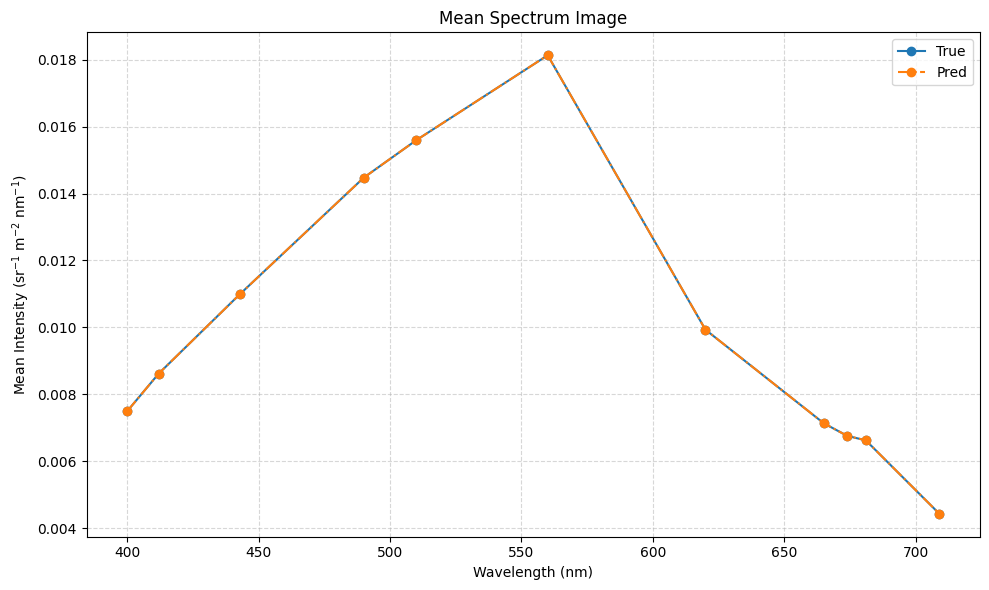

In [27]:
# Validate the normalization/denormalization to ensure it scales up/down correct.

orig_array = stacked_array[:, :, :, :11].copy()
print(f'Min: {np.nanmin(orig_array)}, Max: {np.nanmax(orig_array)}, Sum: {np.nansum(orig_array)}')
temp_normalized_array, GRmax = normalize(orig_array)
print(f'Min: {np.nanmin(temp_normalized_array)}, Max: {np.nanmax(temp_normalized_array)}, Sum: {np.nansum(temp_normalized_array)}')
denorm = denormalize(temp_normalized_array, GRmax)
print(f'Min: {np.nanmin(denorm)}, Max: {np.nanmax(denorm)}, Sum: {np.nansum(denorm)}')
plot_image_spectrum(orig_array[10], denorm[10])


### Adding time-marker channels

In [28]:
# --- 1. Add seasonal sin/cos encodings ---
def add_time_features(data, dates):
    T, H, W, C = data.shape
    #dates = [start_date + timedelta(days=8*i) for i in range(T)]
    day_of_year = np.array([d.timetuple().tm_yday for d in dates])
    sin_doy = np.sin(2 * np.pi * day_of_year / 365)
    cos_doy = np.cos(2 * np.pi * day_of_year / 365)

    sin_doy = sin_doy[:, None, None, None]
    cos_doy = cos_doy[:, None, None, None]

    sin_doy = np.tile(sin_doy, (1, H, W, 1))
    cos_doy = np.tile(cos_doy, (1, H, W, 1))

    return np.concatenate([data, sin_doy, cos_doy], axis=-1)  # (T, H, W, C+2)


In [29]:
# 1. Add seasonal sin/cos encodings ---
def add_daymarker (data, dates):
    T, H, W, C = data.shape
    #dates = [start_date + timedelta(days=8*i) for i in range(T)]
    day_of_year = np.array([d.timetuple().tm_yday for d in dates])
    sin_doy = (day_of_year / 365)
    cos_doy = (day_of_year/day_of_year) # Convert to numpy array

    sin_doy = sin_doy[:, None, None, None]
    cos_doy = cos_doy[:, None, None, None]

    sin_doy = np.tile(sin_doy, (1, H, W, 1))
    cos_doy = np.tile(cos_doy, (1, H, W, 1))

    return np.concatenate([data, sin_doy, cos_doy], axis=-1)  # (T, H, W, C+2)

## Main processing

Extract mask: Extract the mask across all days and all channels.

Normalize: The stacked array needs to be MinMax scaled between -1 and +1

In [30]:
valid_mask = np.isfinite(stacked_array).astype(np.float32)  # 1 where finite, 0 where NaN

scaled_array, GRmax = normalize(stacked_array, eps=1e-8)

print(stacked_array.shape, scaled_array.shape, valid_mask.shape)

Rmax[0]: 0.057120002806186676
Rmax[1]: 0.055385999381542206
Rmax[2]: 0.05127999931573868
Rmax[3]: 0.04602999985218048
Rmax[4]: 0.04588400200009346
Rmax[5]: 0.05257800221443176
Rmax[6]: 0.05380599945783615
Rmax[7]: 0.0516900010406971
Rmax[8]: 0.050732001662254333
Rmax[9]: 0.05065400153398514
Rmax[10]: 0.04241599887609482
(168, 93, 163, 11) (168, 93, 163, 11) (168, 93, 163, 11)


### Spot check both scaled and unscaled data

Min: -1.0, Max: 0.4883410930633545


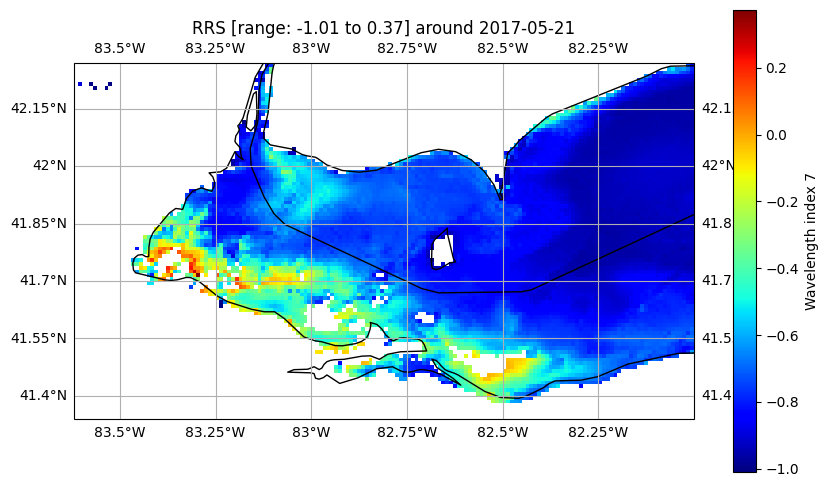

In [31]:
# single channel: 7
# day: 10

# Scaled data
data = scaled_array[10:11,:,:,0:11]
startdate = dates_list[10]
plot_single_channel(lat, lon, startdate, data, waveindex=7)

Min: 0.0, Max: 0.03912699967622757


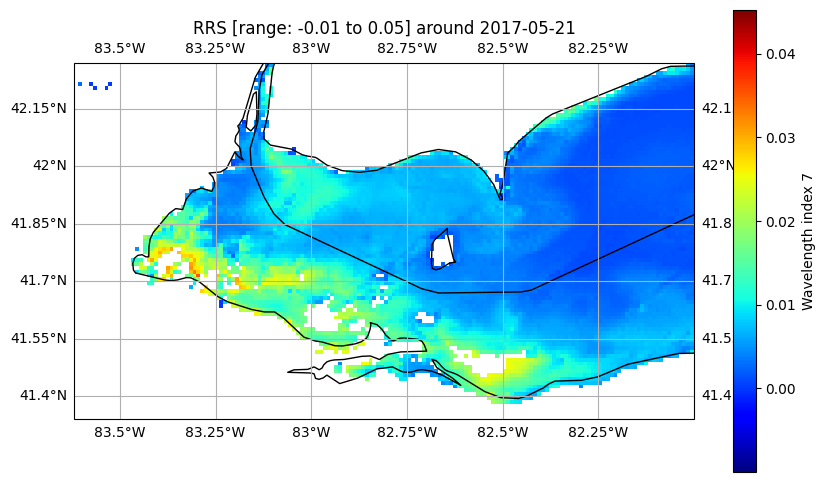

In [32]:
# unscaled data
data = stacked_array[10:11,:,:,0:11]
startdate = dates_list[10]
plot_single_channel(lat, lon, startdate, data, waveindex=7)

In [33]:
# scaled_array is the original dataset: # (225, 93, 163, 11)
print(f'Original: {scaled_array.shape}')

# Add two more dimensions for time
scaled_array = add_time_features(scaled_array, dates_list)
print(f'TimeDims added: {scaled_array.shape}')

# Create a mask across all data (across days, lat, lon, channels)
mask = ~np.isnan(scaled_array[..., :11]).any(axis=-1, keepdims=True)

print(f'Mask shape: {mask.shape}')

# Replace NaNs with a 0.0
scaled_array[..., :11] = np.nan_to_num(scaled_array[..., :11], nan=0.0)

# Add the mask as a channel to the original array
data = np.concatenate([scaled_array, mask], axis=-1)

# New dimension should be (225, 93, 163, 13)
print(f'Mask added: {data.shape}')
print(f'Non-masked Pixels: {np.count_nonzero(mask)}')
print(f'Masked Pixels: {np.count_nonzero(~mask)}')

# --- Create train sequences ---

# Create the X and y datasets for training

X = []
y = []

seq_len = 5  # Adjustable
for i in range(len(data) - seq_len):
    X.append(data[i:i+seq_len])
    y.append(data[i+seq_len])  # predict the next frame

X = np.array(X)  # (samples, time, H, W, channels)
y = np.array(y)  # (samples, H, W, channels)

print(X.shape, y.shape)

Original: (168, 93, 163, 11)
TimeDims added: (168, 93, 163, 13)
Mask shape: (168, 93, 163, 1)
Mask added: (168, 93, 163, 14)
Non-masked Pixels: 1268128
Masked Pixels: 1278584
(163, 5, 93, 163, 14) (163, 93, 163, 14)


### Custom MSE loss function
Note that we are applying a mask corresponding to each output image.

In [34]:
def masked_mse_loss(y_true, y_pred):
    # Split last channel as mask (assumes last channel is the mask)
    mask = y_true[..., -1]  # shape: (B, H, W)
    true = y_true[..., :11]  # shape: (B, H, W, C)
    print(mask.shape, true.shape, y_pred.shape)

    # Broadcast mask to match shape of true/pred
    mask = tf.expand_dims(mask, axis=-1)  # shape: (B, H, W, 1)

    squared_error = tf.square(true - y_pred)
    masked_error = squared_error * mask

    # Avoid dividing by zero
    masked_mse = tf.reduce_sum(masked_error) / tf.reduce_sum(mask + 1e-8)
    return masked_mse


### Build the model

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, ConvLSTM2D, BatchNormalization
from tensorflow.keras.optimizers import Adam

model = Sequential([
    # Muthu: Changed input shape from 14 -> 13; Conv to avoid mask channel
    Input(shape=(None, 93, 163, 13)),
    TimeDistributed(Conv2D(32, (3, 3), activation='tanh', padding='same')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(Conv2D(64, (3, 3), activation='tanh', padding='same')),
    TimeDistributed(BatchNormalization()),

    ConvLSTM2D(64, (1, 1), padding='same', return_sequences=False),
    BatchNormalization(),

    Conv2D(11, (3, 3), padding='same', activation='tanh')  # output 11-channel next frame
])

model.compile(optimizer=Adam(1e-4), loss=masked_mse_loss)


In [36]:
# Assuming X.shape = (num_samples, ...) where samples are ordered in time

# There are 225 weeks across 4 years.. Each year is approx 52 weeks.
# We will divide this into 3 years of training and 1 year validation.

split_index = int(0.8 * len(X))

X_train = X[:split_index][:,:,:,:,0:13]
X_val = X[split_index:][:,:,:,:,0:13]

y_train = y[:split_index]
y_val = y[split_index:]

In [37]:
print(f'X Train: {X_train.shape} Val: {X_val.shape}')
print(f'Y Train: {y_train.shape} Val: {y_val.shape}')
print(f'X_train: Min {np.nanmin(X_train)}, Max {np.nanmax(X_train)}')
print(f'X_val: Min {np.nanmin(X_val)}, Max {np.nanmax(X_val)}')

X Train: (130, 5, 93, 163, 13) Val: (33, 5, 93, 163, 13)
Y Train: (130, 93, 163, 14) Val: (33, 93, 163, 14)
X_train: Min -1.0, Max 1.0
X_val: Min -1.0, Max 1.0


In [38]:
history = model.fit(
    x=X_train,                   # shape: (N, T, H, W, C)
    y=y_train,                   # shape: (N, H, W, 11)
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=4
)

Epoch 1/20
(None, 93, 163) (None, 93, 163, 11) (None, 93, 163, 11)
(None, 93, 163) (None, 93, 163, 11) (None, 93, 163, 11)
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - loss: 6.9071(None, 93, 163) (None, 93, 163, 11) (None, 93, 163, 11)
33/33 ━━━━━━━━━━━━━━━━━━━━ 29s 411ms/step - loss: 6.8357 - val_loss: 2.0230
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 122ms/step - loss: 1.6330 - val_loss: 1.8499
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - loss: 1.1999 - val_loss: 1.6632
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - loss: 1.0821 - val_loss: 1.4707
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - loss: 0.8975 - val_loss: 1.3293
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - loss: 0.7948 - val_loss: 1.1332
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - loss: 0.6955 - val_loss: 1.0242
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - loss: 0.6440 - val_loss: 0.7927
Epoch 9/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - loss: 0.6030 - val_loss: 0.7507
E

In [39]:
# prompt: save the trained model to local file

model.save('my_model.keras')

In [40]:
def predict_and_denorm(model, X_test, y_test):
  y_pred = model.predict(X_test)

  # The last channel in y_test is the mask channel
  valid_mask = y_test[..., -1].astype(bool)
  true_frame = y_test[..., :11]
  print(f'true_frame: {true_frame.shape}; valid_mask: {valid_mask.shape}')
  pred_frame = y_pred[0, :, :, :11]

  # Broadcast the mask to all 11 channels
  true = np.where(valid_mask[..., np.newaxis], true_frame, np.nan)
  pred = np.where(valid_mask[..., np.newaxis], pred_frame, np.nan)

  # Add an extra dimension simulating the days dimension
  true = np.expand_dims(true, axis=0)
  pred = np.expand_dims(pred, axis=0)

  # Bring values back to [0,1] range
  true = denormalize(true, GRmax)
  pred = denormalize(pred, GRmax)

  error = np.where(valid_mask[..., np.newaxis], pred - true, np.nan)
  return true, pred, error




In [41]:
sample = 5
date = dates_list[sample]

print(f'Sample Date: {dates_list[sample]}')

X_test = X[sample:sample+1,...][:,:,:,:,0:13]
y_test = y[sample]

print(X_test.shape, y_test.shape)

Sample Date: 2017-04-02 00:00:00
(1, 5, 93, 163, 13) (93, 163, 14)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
true_frame: (93, 163, 11); valid_mask: (93, 163)
Min: 0.0, Max: 0.03912700064345742


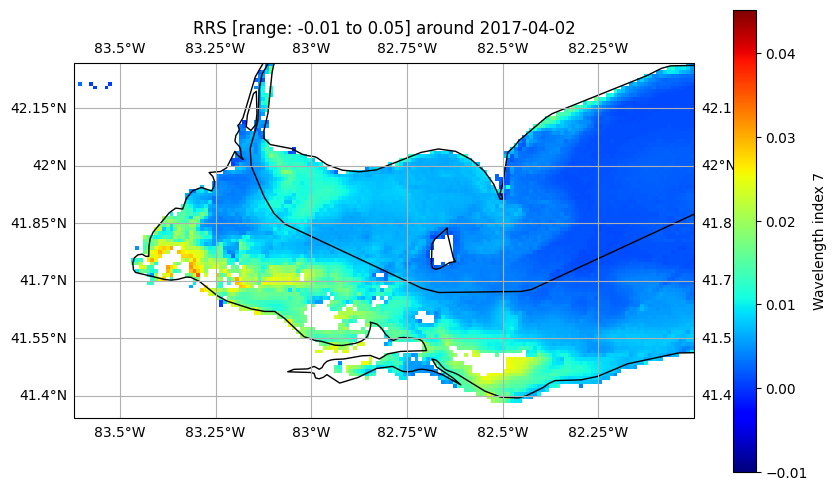

Min: 3.513839692459442e-05, Max: 0.04668275639414787


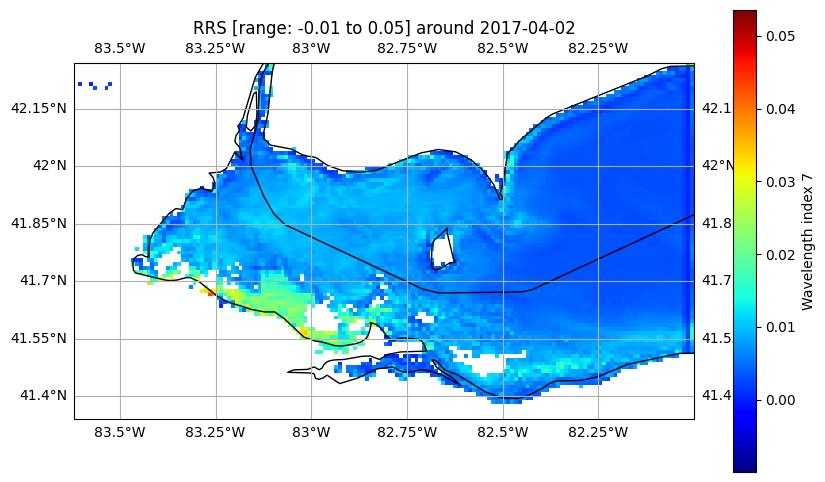

Min: -0.028018190613964933, Max: 0.04273454102999352


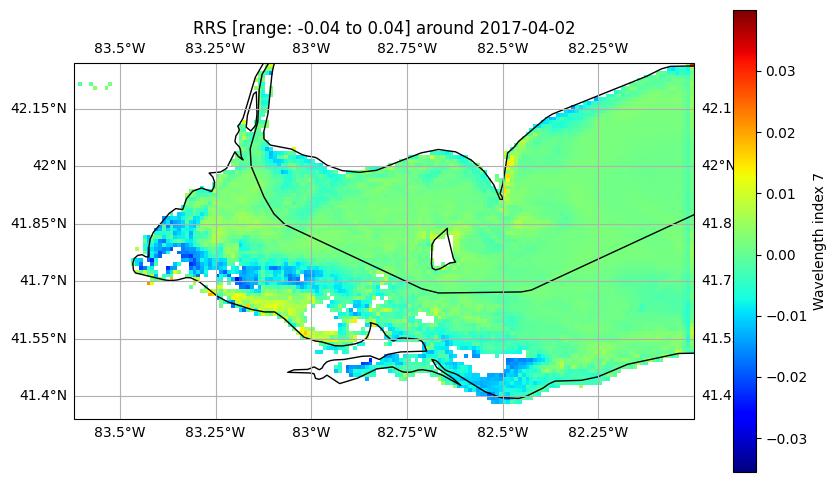

In [42]:
true, pred, error = predict_and_denorm(model, X_test, y_test)
plot_single_channel(lat, lon, date, true, waveindex=7)
plot_single_channel(lat, lon, date, pred, waveindex=7)
plot_single_channel(lat, lon, date, error, waveindex=7)

(11,) (11,)


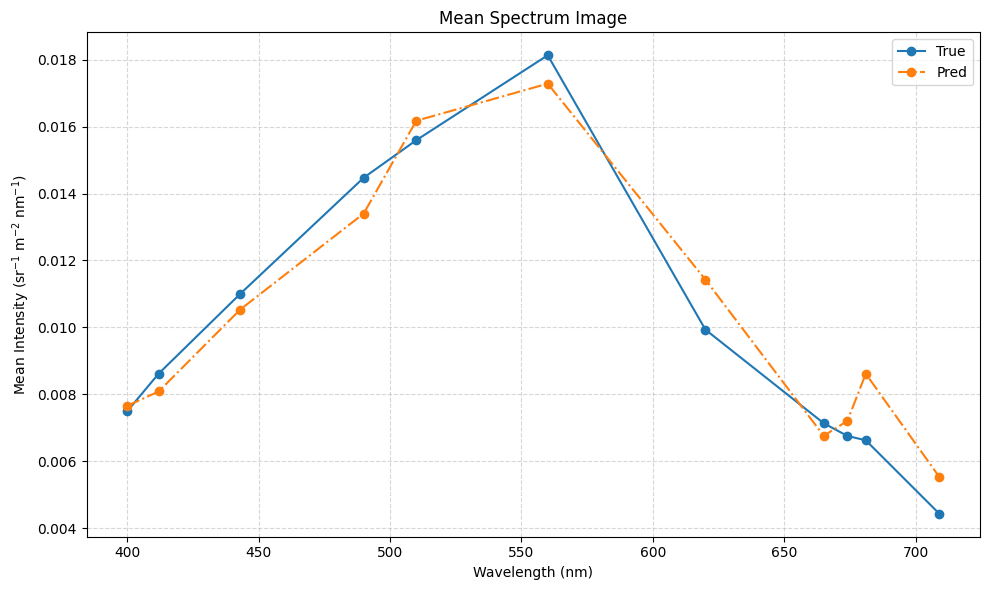

In [43]:
plot_image_spectrum(true[0], pred[0])


In [44]:
def plot_image_ndci(data, start_date, band_665_index=7, band_708_index=10):
    import cartopy as crs
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    import cv2
    from matplotlib.patches import Polygon

    #lat, lon, start_date, data = get_numpy_data_from_file(data_path, metadata_path)

    start_date = date

    # Suppose you know the band indices:
    band_665_index = 7   # replace with actual index for 665 nm
    band_708_index = 10  # replace with actual index for 708 nm

    # Extract the two bands
    rrs_665 = data[0][:, :, band_665_index]
    rrs_708 = data[0][:, :, band_708_index]

    # Compute NDCI safely (avoid division by zero)
    numerator = rrs_708 - rrs_665
    denominator = rrs_708 + rrs_665

    valid_mask = np.isfinite(denominator) & (denominator != 0)
    ndci = np.full_like(denominator, np.nan, dtype=np.float32)
    ndci[valid_mask] = numerator[valid_mask] / denominator[valid_mask]


    # --- Plot on Cartopy ---
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

    # Set map extent to Lake Erie region
    ax.set_extent([-83.62, -82.0, 41.34, 42.27], crs=ccrs.PlateCarree())
    #ax.set_extent([-83.25, -82.5, 41.4, 41.6], crs=ccrs.PlateCarree())

    # Add map features
    ax.coastlines(resolution='10m')
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none')
    ax.gridlines(draw_labels=True)

    # Plot reflectance
    im = ax.pcolormesh(lon, lat, ndci, cmap='jet', shading='auto', vmin=-1, vmax=1, transform=ccrs.PlateCarree())

    # Add colorbar and labels
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', label='log(chloro_a)')

    plt.title(f"NDCI [range: -1 to +1] around {start_date.date()}")
    plt.show()


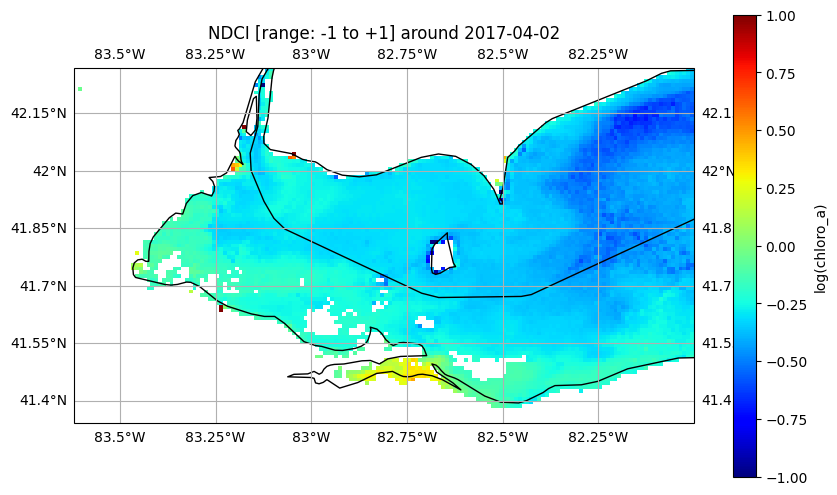

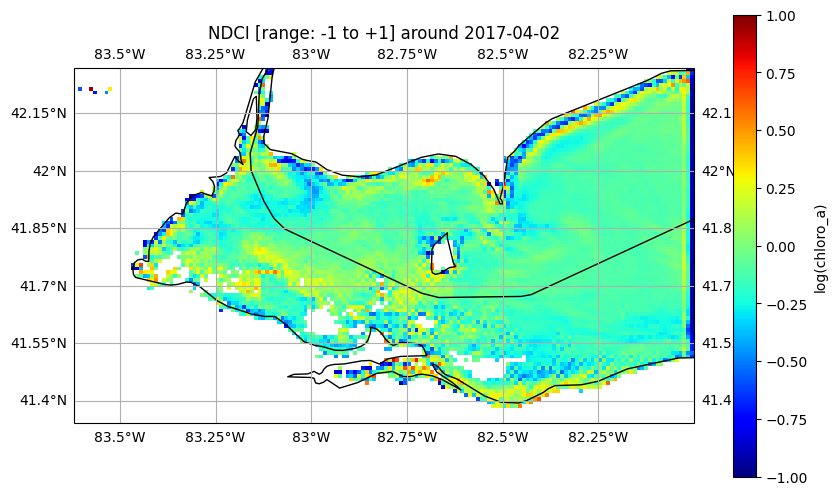

In [45]:
# Call the plot_ndci function with the predicted data and the predicted date
plot_image_ndci(true, date, band_665_index=7, band_708_index=10)
plot_image_ndci(pred, date, band_665_index=7, band_708_index=10)

In [46]:
# Load from saved model
from tensorflow.keras.models import load_model
mymodel = load_model('my_model.keras', custom_objects={'masked_mse_loss': masked_mse_loss})

sample = 76
date = dates_list[sample]

print(f'Sample Date: {dates_list[sample]}')

X_test = X[sample:sample+1,...][:,:,:,:,0:13]
y_test = y[sample]

print(X_test.shape, y_test.shape)


Sample Date: 2019-04-29 00:00:00
(1, 5, 93, 163, 13) (93, 163, 14)


In [47]:
dates_list[66:76]

[datetime.datetime(2018, 11, 25, 0, 0),
 datetime.datetime(2018, 12, 8, 0, 0),
 datetime.datetime(2018, 12, 15, 0, 0),
 datetime.datetime(2018, 12, 22, 0, 0),
 datetime.datetime(2019, 1, 7, 0, 0),
 datetime.datetime(2019, 3, 18, 0, 0),
 datetime.datetime(2019, 3, 25, 0, 0),
 datetime.datetime(2019, 4, 1, 0, 0),
 datetime.datetime(2019, 4, 8, 0, 0),
 datetime.datetime(2019, 4, 15, 0, 0)]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
true_frame: (93, 163, 11); valid_mask: (93, 163)
Min: 0.0, Max: 0.03934000195884302


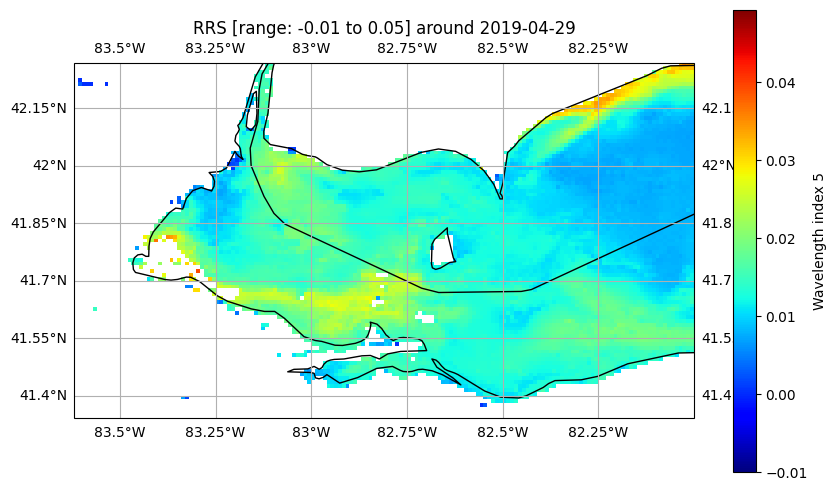

Min: 7.773301331326365e-05, Max: 0.04816504567861557


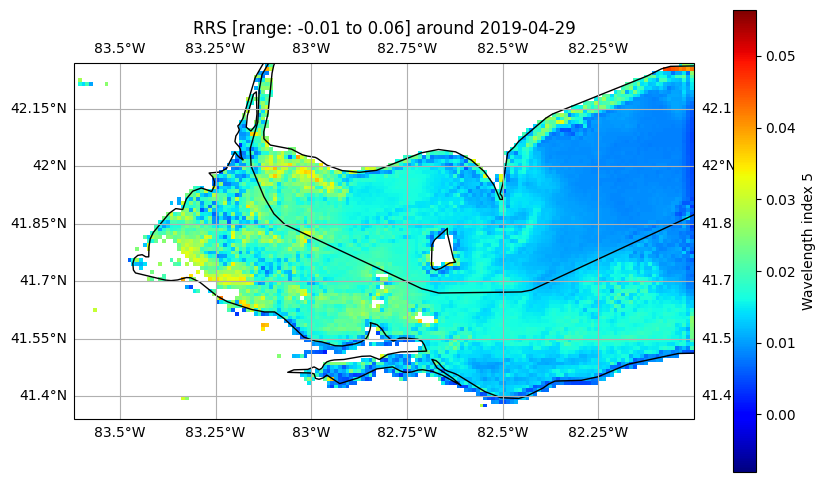

Min: -0.02395648853492105, Max: 0.04805067926645279


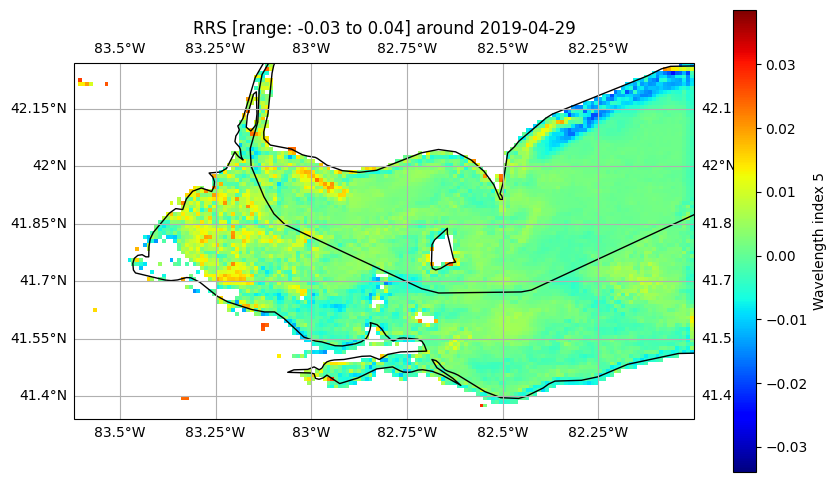

In [48]:
true, pred, error = predict_and_denorm(mymodel, X_test, y_test)

plot_single_channel(lat, lon, date, true, waveindex=5)
plot_single_channel(lat, lon, date, pred, waveindex=5)
plot_single_channel(lat, lon, date, error, waveindex=5)

(11,) (11,)


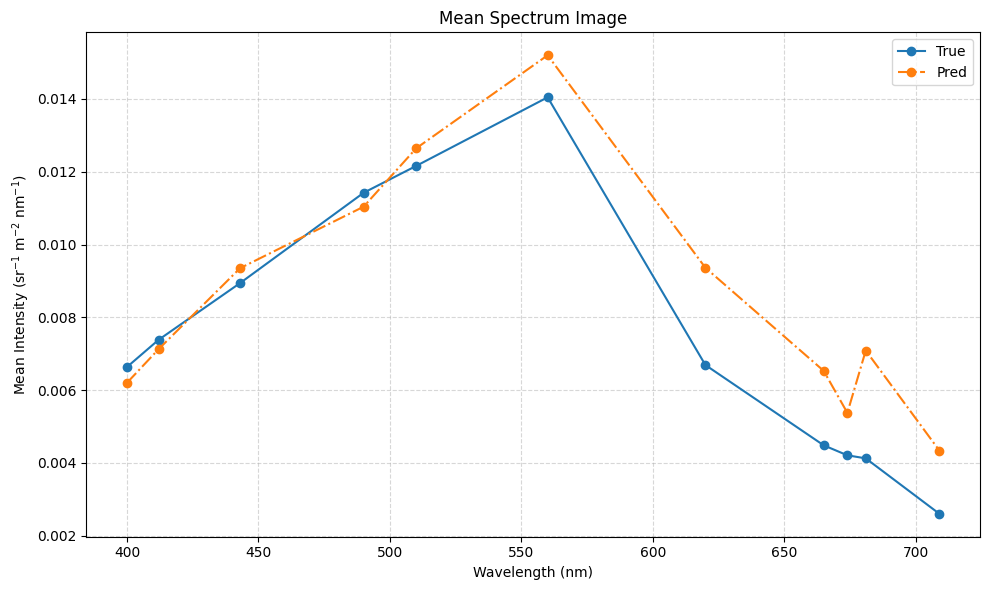

In [49]:
plot_image_spectrum(true[0], pred[0])
